In [1]:
import random
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
RANDOM_SEED = 42

names = {
        'length_ratio': 'Compression ratio',
        'levenshtein': 'Levenshtein similarity',    
        'lex_complexity': 'WordRank ratio',
        'dep_tree_depth': 'Dependency tree depth ratio',
    }

# lang = 'de' # en
lang = 'en'
data_path = Path(f'/srv/scratch6/kew/ats/data/{lang}/data_stats')
plots_path = Path('/home/user/kew/INSTALLS/fudge/analysis/plots')


In [3]:
def make_row_plots(df, level, dataset_name, grid_x=names, outpath=None, llim=0.0, rlim=1.25):

    sns.set_context('paper')

    fig, axes = plt.subplots(1, len(grid_x), figsize=(len(grid_x)*4, 4), sharey=False)

    lines, labels = [], []
    if level == 'all':
        for i, k in enumerate(list(grid_x.keys())):
            sns.histplot(
                df, x=k, ax=axes[i], hue='level', 
                binwidth=0.05, stat='density', kde=True, 
                linewidth=0.1, alpha=0.7, shrink=1.0, 
                legend=True if i == len(grid_x)-1 else False
            )
            axes[i].set_xlim(left=llim, right=rlim)
            axes[i].set_xticks(np.arange(llim, rlim+0.05, 0.25))
            axes[i].set_xlabel(grid_x[k])
        
        title = f'{dataset_name} - all levels'
        fig.suptitle(title)    
    else:
        df = df[df['level'] == level]
        for i, k in enumerate(grid_x.keys()):
            sns.histplot(df, x=k, ax=axes[i], bins=20, binwidth=0.05, stat='density', linewidth=0.1, alpha=0.7, shrink=1.0)
            axes[i].set_xlim(left=llim, right=rlim)
            axes[i].set_xticks(np.arange(llim, rlim+0.05, 0.25))
            axes[i].set_xlabel(grid_x[k])
        title = f'{dataset_name} level {level}'
        fig.suptitle(title)
    
    fig.set_tight_layout(True)

    if outpath:
        outfile = outpath / f'{dataset_name.lower()}_level_{level}.png'
        plt.savefig(outfile, dpi=300)
        print(f'saved plot to {outfile}')

    return

def make_facet_grid(df, title, dataset_name, grid_x=names, outpath=None, llim=0.0, rlim=1.25):
    """Reproduces a facet grid for all newsela levels, similar to https://aclanthology.org/2020.lrec-1.577"""

    sns.set_context('paper')
    n_bins = 50
    
    grid_x = names
    grid_y = sorted(df['level'].unique())
    
    fig, axes = plt.subplots(len(grid_y), len(grid_x), figsize=(len(grid_x)*3, len(grid_y)*2), sharey=True, sharex=True, tight_layout=False)

    for i, level in enumerate(grid_y):
        for j, k in enumerate(grid_x.keys()):
            sub_df = df[df['level'] == level]
            sns.histplot(sub_df, x=k, ax=axes[i][j], binwidth=0.05, stat='density', linewidth=0.1, alpha=0.7, legend=False)  
            axes[i][j].set_xlim(left=llim, right=rlim)
            axes[i][j].set_xlabel(grid_x[k])
            axes[i][j].set_xticks(np.arange(llim, rlim+0.05, 0.25))
            if j == 0:
                axes[i][j].set_ylabel(f'level {level}')
            else:
                axes[i][j].set_ylabel(None)

    if title:
        fig.suptitle(title)
    
    # shared axis labels
    fig.supxlabel('Attributes')
    fig.supylabel(f'{dataset_name} Simplification Levels')

    fig.set_tight_layout(True)
    
    if outpath:
        outfile = outpath / f'{dataset_name.lower()}_level_attributes_facet.png'
        plt.savefig(outfile, dpi=300)
        print(f'saved plot to {outfile}')

    return


In [4]:
dfs = []

if lang == 'en':
    for file in data_path.glob('newsela_manual*'):
        df = pd.read_csv(file, sep='\t')
        df['level'] = file.stem[-1]
        dfs.append(df)
elif lang == 'de':
    for file in data_path.glob('apa_capito*'):
        df = pd.read_csv(file, sep='\t')
        df['level'] = file.stem.split('_')[-1]
        dfs.append(df)

df = pd.concat(dfs).reset_index(drop=True)
# df.head()

# downsample dataframe for equal number of sentences in each level - better plots
min_level_count = min(df['level'].value_counts())
print(len(df))
df = df.groupby(['level']).sample(n=min_level_count, random_state=RANDOM_SEED, replace=False)
print(len(df))
print(df['level'].value_counts())

print('**** length_ratio')
print(df.groupby('level')['length_ratio'].describe())
print('**** lex_complexity')
print(df.groupby('level')['lex_complexity'].describe())
print('**** levenshtein')
print(df.groupby('level')['levenshtein'].describe())
print('**** dep_tree_depth')
print(df.groupby('level')['dep_tree_depth'].describe())
print('**** Sentence splits')
print(df.groupby('level')['Sentence splits'].describe())

5033
3712
1    928
2    928
3    928
4    928
Name: level, dtype: int64
**** length_ratio
       count      mean       std       min       25%       50%       75%  \
level                                                                      
1      928.0  1.055122  0.472343  0.276923  0.984276  1.000000  1.028227   
2      928.0  1.022534  0.382983  0.260870  0.884550  1.000000  1.062748   
3      928.0  0.942216  0.468215  0.095652  0.704099  0.922187  1.035714   
4      928.0  0.877890  0.544315  0.100000  0.559000  0.834660  1.021943   

             max  
level             
1      10.454545  
2       5.666667  
3       7.818182  
4       7.909091  
**** lex_complexity
       count      mean       std       min       25%       50%       75%  \
level                                                                      
1      928.0  0.991265  0.053202  0.697672  0.988626  1.000000  1.000000   
2      928.0  0.985747  0.074565  0.427344  0.960439  1.000000  1.000000   
3      928.0  0

plotted en 1
saved plot to /home/user/kew/INSTALLS/fudge/analysis/plots/newsela_level_1.png
plotted en 2
saved plot to /home/user/kew/INSTALLS/fudge/analysis/plots/newsela_level_2.png
plotted en 3
saved plot to /home/user/kew/INSTALLS/fudge/analysis/plots/newsela_level_3.png
plotted en 4
saved plot to /home/user/kew/INSTALLS/fudge/analysis/plots/newsela_level_4.png
plotted en all
saved plot to /home/user/kew/INSTALLS/fudge/analysis/plots/newsela_level_all.png
saved plot to /home/user/kew/INSTALLS/fudge/analysis/plots/newsela_level_attributes_facet.png


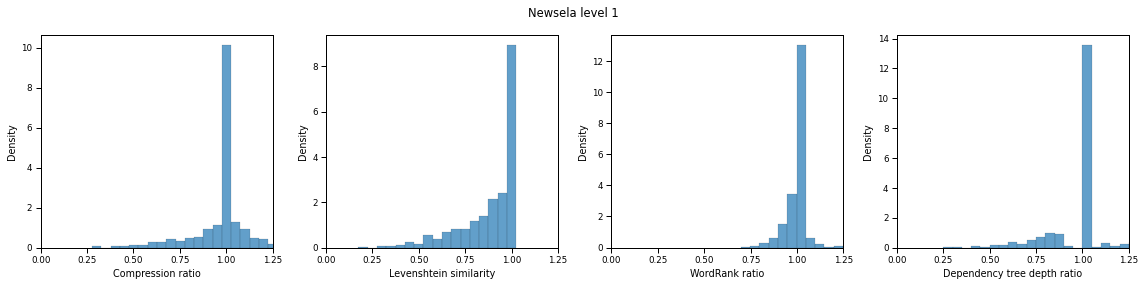

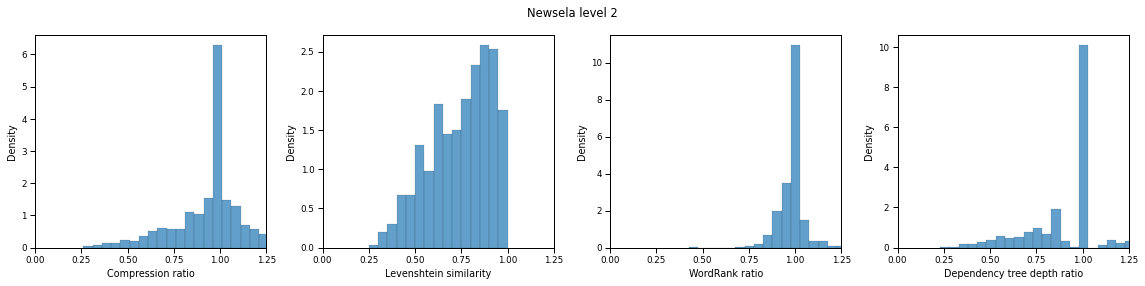

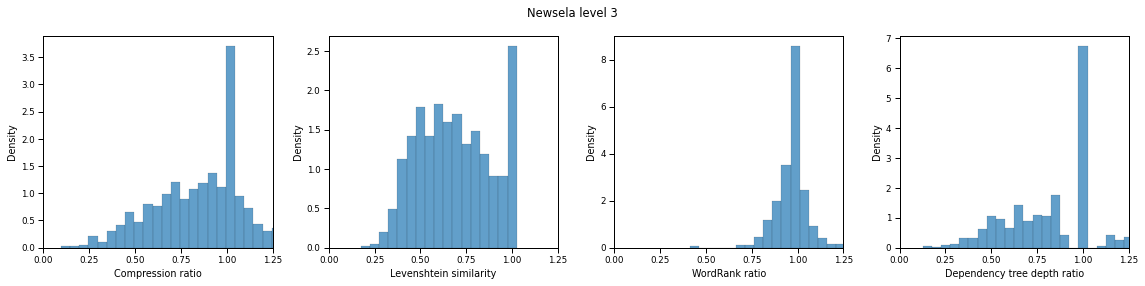

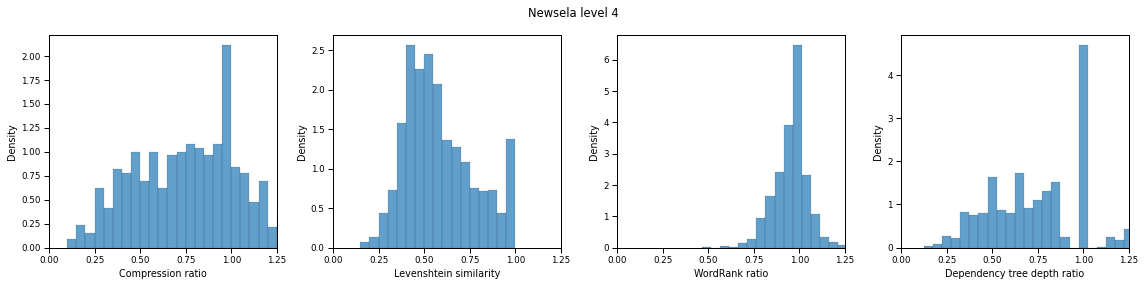

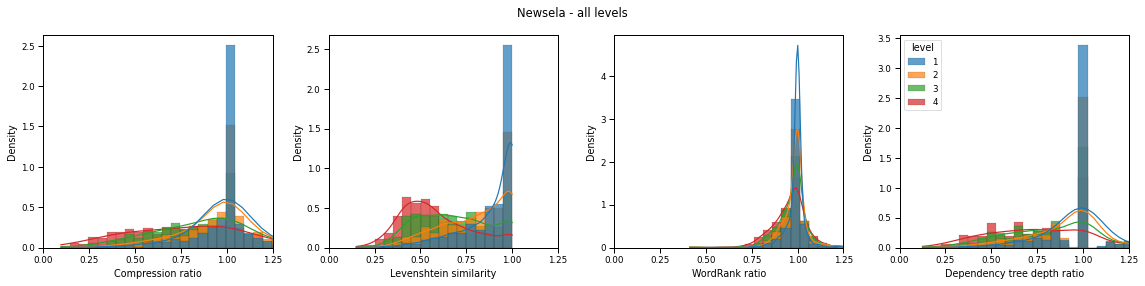

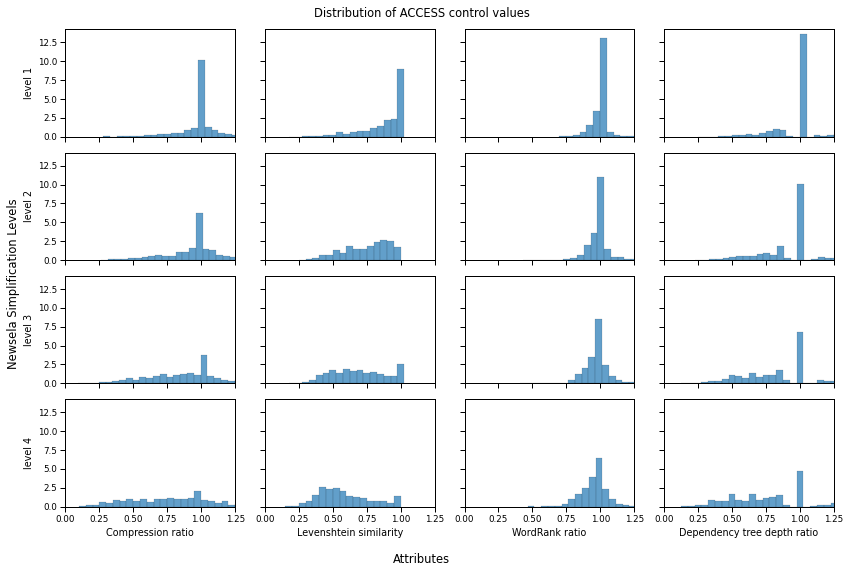

In [5]:
if lang == 'en':
    for level in ['1', '2', '3', '4', 'all']:
        print(f'plotted {lang} {level}')
        make_row_plots(df, level=level, dataset_name='Newsela', grid_x=names, outpath=plots_path)
    make_facet_grid(df, title='Distribution of ACCESS control values', dataset_name='Newsela', grid_x=names, outpath=plots_path)

elif lang == 'de':
    for level in ['a1', 'a2', 'b1', 'all']:
        print(f'plotted {lang} {level}')
        make_row_plots(df, level=level, dataset_name='APA-Capito', grid_x=names, outpath=plots_path)
    make_facet_grid(df, title='Distribution of ACCESS control values', dataset_name='APA-Capito', grid_x=names, outpath=plots_path)


In [91]:
# tips = sns.load_dataset("tips")
# tips
# ax = sns.violinplot(x="day", y="total_bill", data=tips)

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [83]:
# def make_box_plots(df, level, dataset_name, grid_x=names, outpath=None, llim=0.0, rlim=1.25):

#     sns.set_context('paper')

#     fig, axes = plt.subplots(1, len(grid_x), figsize=(len(grid_x)*4, 4), sharey=False)

#     if level == 'all':
#         for i, k in enumerate(grid_x.keys()):
#             print(k)
#             sns.violinplot(df, x='level', y=k, ax=axes[i], linewidth=0.1, alpha=0.7, legend=False)
# #             axes[i].set_xlim(left=llim, right=rlim)
# #             axes[i].set_xticks(np.arange(llim, rlim+0.05, 0.25))
# #             axes[i].set_xlabel(grid_x[k])
#         title = f'{dataset_name} - all levels'
#         fig.suptitle(title)    
#     else:
#         df = df[df['level'] == level]
#         for i, k in enumerate(grid_x.keys()):
#             sns.histplot(df, x=k, ax=axes[i], bins=20, binwidth=0.1, stat='density', linewidth=0.1, alpha=0.7, shrink=1.0)
#             axes[i].set_xlim(left=llim, right=rlim)
#             axes[i].set_xticks(np.arange(llim, rlim+0.05, 0.25))
#             axes[i].set_xlabel(grid_x[k])
#         title = f'{dataset_name} level {level}'
#         fig.suptitle(title)
    
#     fig.set_tight_layout(True)

#     if outpath:
#         outfile = outpath / f'{dataset_name.lower()}_level_{level}.png'
#         plt.savefig(outfile, dpi=300)
#         print(f'saved plot to {outfile}')

#     return

# make_box_plots(df, level='all', dataset_name='Newsela', grid_x=names, outpath=plots_path)

<AxesSubplot:xlabel='Count', ylabel='lex_complexity'>

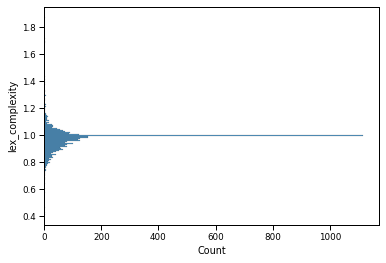

In [98]:
# df
# sns.histplot(df, y='lex_complexity')